In [274]:
import os
import pandas as pd
import os.path as osp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Load files

In [275]:
os.getcwd()

'D:\\Project- Electro\\social_behavior_electro\\data_organization\\python'

In [276]:
folder_path = osp.join('..','..','analysis')
path_to_aversive = osp.join(folder_path,
                            'Population analysis results for LFP Coherence - Encounter-PreEncounter_4-12_30-80_aversive.xlsx')
path_to_affiliative = osp.join(folder_path,
                               'Population analysis results for LFP Coherence - Encounter-PreEncounter_4-12_30-80_affiliative.xlsx')
path_to_common_areas = osp.join(folder_path, 'common_area_pairs_w5_sessions.xlsx')



In [277]:
df_aff = pd.read_excel(path_to_affiliative,None)
df_avv = pd.read_excel(path_to_aversive,None)

df_files_avv = pd.read_excel(path_to_aversive,'Uploaded files', header=None)
df_files_aff = pd.read_excel(path_to_affiliative,'Uploaded files', header=None)

df_areas = pd.read_excel(path_to_common_areas)


## Get info

### Number of sessions in each state

In [278]:
def get_number_of_sessions(df):
    max_len = 0
    for df_t in df.values():
        # find the max length
        max_len = max(max_len, len(df_t))
    return max_len

In [279]:
n_sssions_aff = get_number_of_sessions(df=df_aff)
n_sssions_avv = get_number_of_sessions(df=df_avv)

In [280]:
# I had to hard code this part since the names on the tables are different
important_pairs_in_data = [
    ('Area 111 MeA', 'Area 13 CeA'),
    ('Area 111 MeA', 'Area 112 BMA'),
    ('Area 111 MeA', 'Area 14 AA/ACO/VEN'),
    ('Area 111 MeA', 'Area 16 EA'),
    ('Area 111 MeA', 'Area 12 STIA'),
    ('Area 2 MePV', 'Area 112 BMA'),
    ('Area 13 CeA', 'Area 12 STIA'),
    ('Area 112 BMA', 'Area 14 AA/ACO/VEN')
]


## Get important pairs directly from the tables

In [281]:
# Each pair must appear in at least 5 session in each state
'''
- loop over all possible pairs and count the number of session for each pair
- keep only the pairs that were mesured only match conditions
'''
def get_area_names(df):
    all_areas = [area.replace('During','').replace('Before','').replace('First','').replace('Second','') for area in list(df.keys())]
    all_areas = set(all_areas)
    all_areas = all_areas - set(['NormMinus','Uploaded files'])
    return all_areas
areas_aff = get_area_names(df_aff)
areas_avv = get_area_names(df_avv)

common_areas = areas_aff.intersection(areas_avv)

def search_tuple_in_array_no_order(t, t_array):
    t_array = list(t_array)
    for t2 in t_array:
        if set(t) == set(t2):
            return True
        return False
    

def get_n_session_for_each_pair(df):
    MIN_N_SESSION = 5
    ret = dict()
    for area_sheet, data in df.items():
        # Only look at "First" (frequency range)
        if 'Norm' in area_sheet or 'Uploaded files' in area_sheet or 'Second' in area_sheet:
            continue
        area_name = area_sheet.replace('During','').replace('Before','').replace('First','')
        n_sessions = data.count()
        valid_session_ind = n_sessions>=MIN_N_SESSION
        valid_area_pairs = list(n_sessions[valid_session_ind].index)
        
        for area2 in valid_area_pairs:
            if search_tuple_in_array_no_order((area_name, area2), ret.keys()):
                continue
            ret[tuple(sorted([area_name, area2]))] = n_sessions[area2]
         
    return ret



In [282]:
valid_avv = get_n_session_for_each_pair(df = df_avv)
valid_aff = get_n_session_for_each_pair(df = df_aff)


In [283]:
# combine two dicts, keep only common keys
# folter non common pairs
common_pairs = set(valid_avv.keys()).intersection(set(valid_aff.keys())) # this is ok since the tuples are sorted
# convert to dataframe
dict_sum = {}
dict_sum['affiliative'] = {p:valid_aff[p] for p in common_pairs}
dict_sum['aversive'] = {p:valid_avv[p] for p in common_pairs}

In [284]:
df_counts = pd.DataFrame.from_dict(dict_sum)
df_counts

affiliative  aversive
AA  BMA             5         6
    MeD            10        14
CeA MeD             6        12
BMA MePV            9         6
    MeD            15         7
MeD STIA            5        11
CeA STIA            5        10
EA  MeD             8        11

## Extract means and std

In [285]:
def fix_file_paths(df_files):
    
    df_files = df_files.rename(columns={df_files.columns[0]:'timestamps', df_files.columns[0]:'lfp', })
    
    return df_files
    
def extreact_vals(df, pair, df_file_paths, range_of_freq='First', call_num=0):

    all_sheet_names = df.keys()
    sheet_name = [n for n in all_sheet_names if range_of_freq in n and pair[0] in n][0]
    vals = df[sheet_name][pair[1]].values
    if len(vals)>0:
        non_nan_vals = ~np.isnan(vals)
        vals = vals[np.where(non_nan_vals)]
        try:
            filenames = df_file_paths.iloc[np.where(non_nan_vals)]
        except:
            print('Printing data of df files')
            print(np.where(non_nan_vals))
            print(df_file_paths['lfp'])
            print(range_of_freq)
            return 


    else:
        vals = []
        filenames = []

    if len(vals)==0 and call_num==0:
        vals, filenames = extreact_vals(df, (pair[1],pair[0]),df_file_paths, range_of_freq,call_num=1)
        
    return vals, filenames


In [470]:
df_file_paths_aff = fix_file_paths(df_files_aff)
df_file_paths_avv = fix_file_paths(df_files_avv)

# vals_aff, filenames_aff = extreact_vals(df=df_avv, df_file_paths=df_file_paths_aff, pair=('AA', 'BMA'), range_of_freq='First', call_num=0)

In [287]:
# df_file_paths_aff

In [288]:
filenames.lfp.values

array(['chamber_Rat3-Probe2-sniffing-day1-Behavior_and_Optogenetics_TimeStamps_Probe_A.mat',
       'chamber_Rat3-probe2-sniffing-day4-Behavior_and_Optogenetics_TimeStamps_Probe_A.mat',
       'chamber_Rat4-probe3-sniffing-day2-Behavior_and_Optogenetics_TimeStamps_Probe_A.mat',
       'chamber_Rat4-probe3-sniffing-day3-Behavior_and_Optogenetics_TimeStamps_Probe_A.mat',
       'chamber_Rat15-probe17-day2-Behavior_and_Optogenetics_TimeStamps -.mat',
       'chamber_Rat15-probe17-day3-Behavior_and_Optogenetics_TimeStamps.mat',
       'chamber_Rat16-probe16-day1-Behavior_and_Optogenetics_TimeStamps_Probe_A.mat',
       'chamber_Rat16-Probe16-day2-Behavior_and_Optogenetics_TimeStamps_Probe_A.mat',
       'chamber_Rat16-probe16-day4-Behavior_and_Optogenetics_TimeStamps_Probe_A.mat',
       'chamber_Rat16-probe18-day1-Behavior_and_Optogenetics_TimeStamps.mat',
       'chamber_Rat16-probe18-day2-Behavior_and_Optogenetics_TimeStamps.mat'],
      dtype=object)

In [289]:

# columns names: pair, sosicability, coherence, filenaem 
# first range - 4-12 Hz
# second range - 30-80 Hz
sociability = {'affiliative':df_file_paths_aff,'aversive':df_file_paths_avv}
df_sociability = {'affiliative':df_aff,'aversive':df_avv}
# sociability = {'affiliative':df_file_paths_aff}
# df_sociability = {'affiliative':df_aff}


frequency_bands = {'First':'4-12','Second':'30-80'}

df_sum_list = []
for pair in common_pairs:
    for social in sociability.keys():
        for freq in frequency_bands.keys():

#             try:
            vals, filenames = extreact_vals(
                df=df_sociability[social],
                pair=pair,
                df_file_paths=sociability[social],
                range_of_freq=freq,
                call_num=0)
    
                
            temp_dict ={'area1': pair[0],
                        'area2': pair[1],
                        'sociability': social, 
                        'frequency_band': frequency_bands[freq],
                        'coherence': vals,
                       'files': filenames.lfp.values}
            temp_df = pd.DataFrame.from_dict(temp_dict)
#             temp_df.columns = temp_df.columns[::-1]
            df_sum_list.append(temp_df)
df_sum = pd.concat(df_sum_list)

df_sum_list2= []
for pair in common_pairs:
    for social in sociability:
        for freq in frequency_bands.keys():
            
            vals, filenames = extreact_vals(
                df=df_sociability[social],
                df_file_paths=sociability[social],
                pair=pair,
                range_of_freq=freq,
                call_num=0)
            
            
            temp_dict ={pair: {'sociability': social, 
                               'frequency_band': frequency_bands[freq],
                               'coherence': vals,
                              'files':filenames.lfp.values}}
            temp_df = pd.DataFrame.from_dict(temp_dict).transpose()
#             temp_df.columns = temp_df.columns[::-1]
            df_sum_list2.append(temp_df)
df_sum2 = pd.concat(df_sum_list2)
df_sum2 = df_sum2[df_sum2.columns[::-1]]
df_sum2['mean'] = df_sum2['coherence'].apply(lambda x: np.mean(x))
df_sum2['std'] = df_sum2['coherence'].apply(lambda x: np.std(x))
df_sum2['median'] = df_sum2['coherence'].apply(lambda x: np.median(x))
df_sum2 = df_sum2.reset_index()
df_sum2 = df_sum2.rename(columns={'level_0':'area1', 'level_1': 'area2'})
df_sum2.columns

Index(['area1', 'area2', 'sociability', 'frequency_band', 'files', 'coherence',
       'mean', 'std', 'median'],
      dtype='object')

In [236]:
df_sum2

,area1,area2,sociability,frequency_band,files,coherence,mean,std,median
0,AA,BMA,affiliative,4-12,[chamber_Rat16-probe18-day3-Behavior_and_Optog...,"[-0.08485020103548116, -0.08183394283217837, -...",-0.075196,0.048725,-0.081834
1,AA,BMA,affiliative,30-80,[chamber_Rat16-probe18-day3-Behavior_and_Optog...,"[-0.024921798695603126, -0.019307120745778478,...",-0.014084,0.007428,-0.013666
2,AA,BMA,aversive,4-12,[chamber_Rat16-probe18-day1-Behavior_and_Optog...,"[-0.033212836622513064, 0.025546737796704133, ...",-0.025982,0.063684,-0.004316
3,AA,BMA,aversive,30-80,[chamber_Rat16-probe18-day1-Behavior_and_Optog...,"[0.002800729134647517, 0.0020799764197723114, ...",-0.053587,0.106329,0.000607
4,AA,MeD,affiliative,4-12,[chamber_Rat4-probe3-sniffing-day1-Behavior_an...,"[0.1398851629682244, -0.1245387885406442, -0.1...",-0.128436,0.140949,-0.107049
5,AA,MeD,affiliative,30-80,[chamber_Rat4-probe3-sniffing-day1-Behavior_an...,"[0.08724576069305534, -0.12851674780721942, -0...",-0.027556,0.054493,-0.026070
6,AA,MeD,aversive,4-12,[chamber_Rat4-probe3-sniffing-day2-Behavior_an...,"[0.0405549542609418, -0.019013147896633997, 0....",-0.014978,0.059035,-0.002784
7,AA,MeD,aversive,30-80,[chamber_Rat4-probe3-sniffing-day2-Behavior_an...,"[0.024915433102215112, -0.011742569490603705, ...",-0.002508,0.015192,-0.002191
8,CeA,MeD,affiliative,4-12,[chamber_Rat3-probe2-sniffing-day2-Behavior_an...,"[-0.2783367927282807, -0.1969289180747496, -0....",-0.124849,0.089331,-0.102381
9,CeA,MeD,affiliative,30-80,[chamber_Rat3-probe2-sniffing-day2-Behavior_an...,"[-0.14540752224689185, -0.22748645803561543, -...",-0.074453,0.086853,-0.044104


In [234]:
df_sum.set_index(['files']).sort_index()

,area1,area2,sociability,frequency_band,coherence
files,,,,,
Chamber_Rat22-probe21-Day1-Behavior_and_Optogenetics_TimeStamps.mat,AA,BMA,affiliative,4-12,-0.003328
Chamber_Rat22-probe21-Day1-Behavior_and_Optogenetics_TimeStamps.mat,AA,BMA,affiliative,30-80,-0.013666
Chamber_Rat23-probe22-Day1-Behavior_and_Optogenetics_TimeStamps.mat,AA,MeD,aversive,4-12,-0.018409
Chamber_Rat23-probe22-Day1-Behavior_and_Optogenetics_TimeStamps.mat,AA,MeD,aversive,30-80,-0.017622
Chamber_Rat23-probe22-Day1-Behavior_and_Optogenetics_TimeStamps.mat,CeA,MeD,aversive,4-12,0.001158
...,...,...,...,...,...
chamber_rat14-probe14-day 1-Behavior_and_Optogenetics_TimeStamps.mat,BMA,MePV,affiliative,30-80,0.008206
chamber_rat14-probe14-day 1-Behavior_and_Optogenetics_TimeStamps.mat,BMA,MeD,affiliative,30-80,-0.000660
chamber_rat14-probe14-day 1-Behavior_and_Optogenetics_TimeStamps.mat,BMA,MeD,affiliative,4-12,0.049538


In [71]:
area_pairs = df_sum[['area1','area2']].values
area_pairs = [(a,b) for a,b in area_pairs]
df_sum['area_pairs'] = area_pairs

In [73]:
area_pairs = df_sum2[['area1','area2']].values
area_pairs = [(a,b) for a,b in area_pairs]
df_sum2['area_pairs'] = area_pairs


In [67]:
df_sum2.columns

Index(['area1', 'area2', 'sociability', 'frequency_band', 'coherence', 'mean',
       'std', 'area_pairs', 'zscore_mean'],
      dtype='object')

In [74]:
df_sum2.set_index(['area1', 'area2', 'sociability', 'frequency_band']).unstack(['sociability', 'frequency_band'])['median']

sociability    affiliative            aversive          
frequency_band        4-12     30-80      4-12     30-80
area1 area2                                             
AA    BMA        -0.081834 -0.013666 -0.004316  0.000607
      MeD        -0.107049 -0.026070 -0.002784 -0.002191
BMA   MeD         0.008472 -0.000660 -0.005398 -0.000148
      MePV        0.004017  0.000994 -0.029782 -0.026578
CeA   MeD        -0.102381 -0.044104 -0.009842 -0.002598
      STIA       -0.073944 -0.029949 -0.035234 -0.003435
EA    MeD        -0.101067 -0.010300 -0.108967 -0.035524
MeD   STIA        0.005339  0.020622  0.026095  0.004391

affiliative  aversive
AA  BMA             5         6
    MeD            10        14
CeA MeD             6        12
BMA MePV            9         6
    MeD            15         7
MeD STIA            5        11
CeA STIA            5        10
EA  MeD             8        11

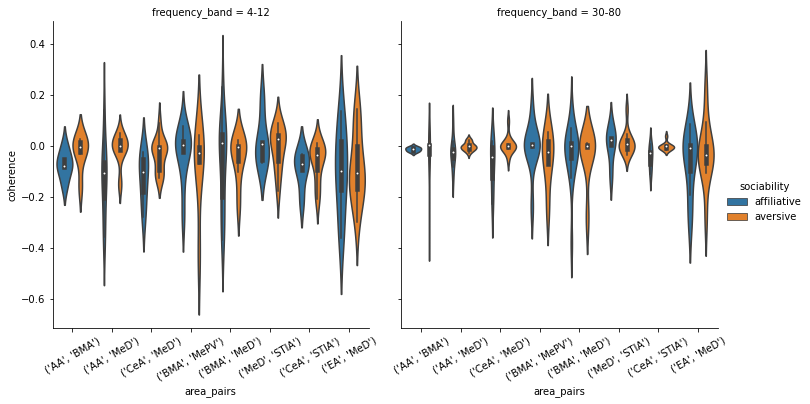

In [24]:
g = sns.catplot(data=df_sum, x='area_pairs', y='coherence', hue='sociability', kind='violin', col='frequency_band')
g.set_xticklabels(rotation=30)
df_counts

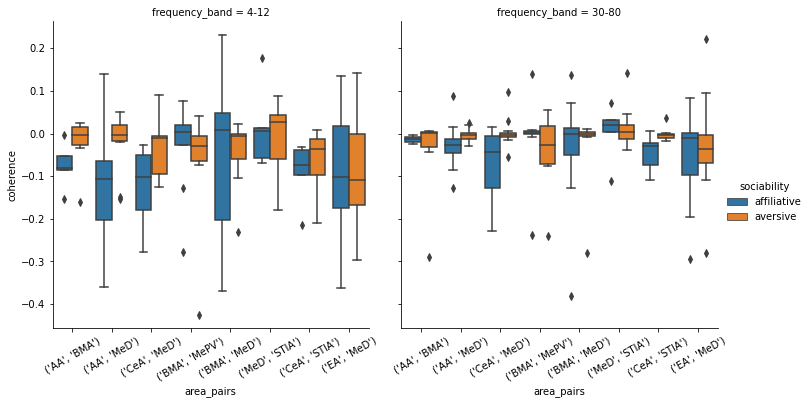

In [25]:
g = sns.catplot(data=df_sum, x='area_pairs', y='coherence', hue='sociability', kind='box', col='frequency_band')
g.set_xticklabels(rotation=30)


## Statistical Analysis

In [26]:
df_sum.to_excel(osp.join(folder_path, 'coherence_summary_table.xlsx'))

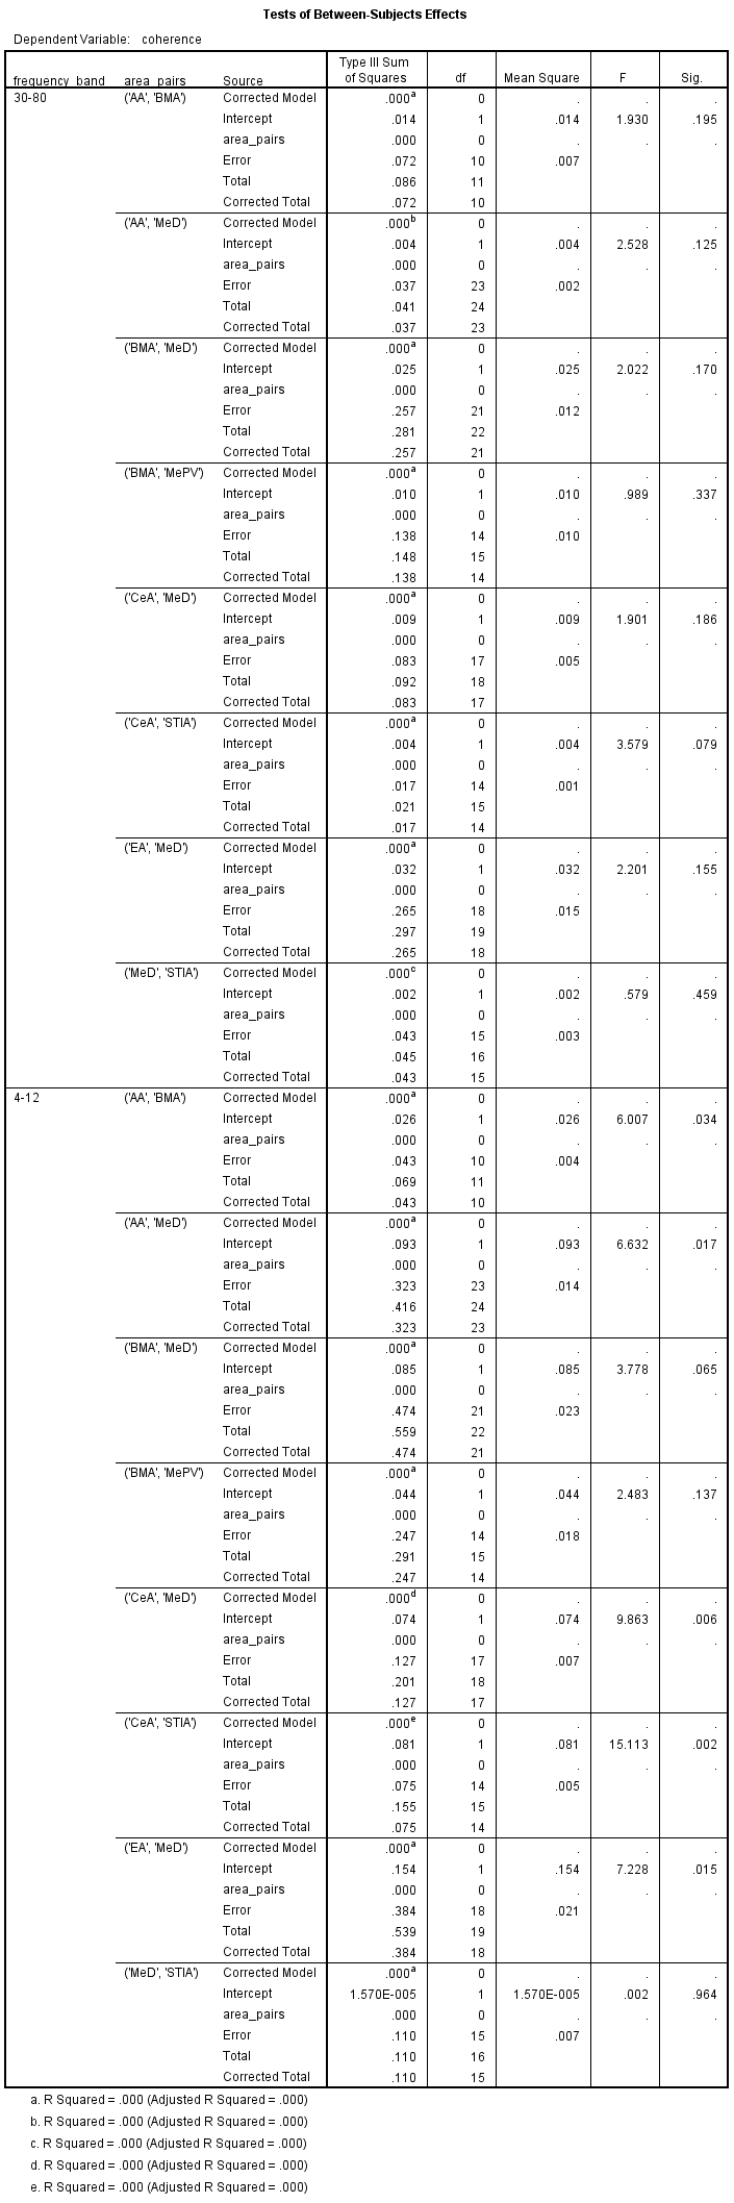

array([('AA', 'BMA'), ('AA', 'MeD'), ('CeA', 'MeD'), ('BMA', 'MePV'),
       ('BMA', 'MeD'), ('MeD', 'STIA'), ('CeA', 'STIA'), ('EA', 'MeD')],
      dtype=object)

In [96]:
from scipy.stats import mannwhitneyu
def mannwhitneyu_test(df, pairs, freq_band):
    ret = {}
    for pair in pairs:
        sub_df = df.loc[(df['area_pairs'] == pair) & (df['frequency_band']==freq_band)]
        vals_1 = sub_df.loc[df['sociability']== 'affiliative' ]['coherence'].values
        vals_2 = sub_df.loc[df['sociability']== 'aversive' ]['coherence'].values
        
#         print(vals_1)
#         print(vals_2)
        
        res = mannwhitneyu(vals_1[0], vals_2[0])
        ret[pair] = {'stat': res.statistic, 'pval': res.pvalue}
    return ret


In [107]:
ret_all = []

pairs = df_sum2['area_pairs'].unique()
ret = mannwhitneyu_test(df_sum2, pairs, '4-12')
ret = pd.DataFrame.from_dict(ret).transpose()
ret['freq'] = '4-12'
ret_all.append(ret)

pairs = df_sum2['area_pairs'].unique()
ret = mannwhitneyu_test(df_sum2, pairs, '30-80')
ret = pd.DataFrame.from_dict(ret).transpose()
ret['freq'] = '30-80'
ret_all.append(ret)

In [443]:
df_sig_pairs = pd.concat(ret_all)
df_sig_pairs = df_sig_pairs.loc[df_sig_pairs['pval']<=0.05]
df_sig_pairs.index.set_names(['area1', 'area2'], inplace=True)
df_sig_pairs = df_sig_pairs.reset_index().set_index(['freq', 'area1', 'area2'])
significant_names = list(df_sig_pairs.index)
significant_names

[('4-12', 'AA', 'MeD'),
 ('4-12', 'CeA', 'MeD'),
 ('30-80', 'AA', 'MeD'),
 ('30-80', 'CeA', 'MeD'),
 ('30-80', 'CeA', 'STIA')]

## Draw a network graph

In [27]:
import networkx as nx
from scipy import stats



In [28]:
mean_co = df_sum2['mean'].values
z_means = stats.zscore(mean_co)
df_sum2['zscore_mean'] = z_means

In [60]:
def plot_network(area1_list, area2_list, vals, pos = None, th=None):
    G = nx.Graph()

    vals = np.round(vals,3)
    if th is None:
        th = np.mean(vals)
    
    # z_score_list_scale = (z_score_list-np.min(z_score_list))/(np.max(z_score_list)-np.min(z_score_list))
    # z_score_list_scale = np.round(z_score_list_scale,3)


    [G.add_edge(a, b, weight=c) for a,b,c in zip(area1_list, area2_list, vals)]


    elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > th]
    esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= th]

    
    if pos is None:
#         pos = nx.spring_layout(G, seed=7)  # positions for all nodes - seed for reproducibility
        pos = nx.planar_layout(G)  # positions for all nodes - seed for reproducibility


#     plt.figure(figsize=(5,10))

    # nodes
    nx.draw_networkx_nodes(G, pos, node_size=700)



    # edges
    nx.draw_networkx_edges(G, pos, edgelist=elarge, width=6)
    nx.draw_networkx_edges(
        G, pos, edgelist=esmall, width=6, alpha=0.5, edge_color="b", style="dashed"
    )

    # node labels
    nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")
    # edge weight labels
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos, edge_labels)


    ax = plt.gca()
    ax.margins(0.08)
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    return pos, ax

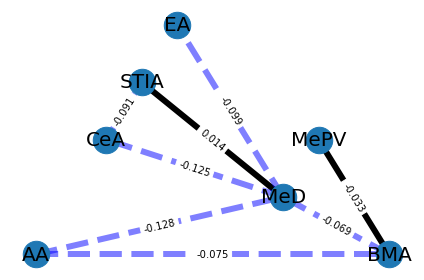

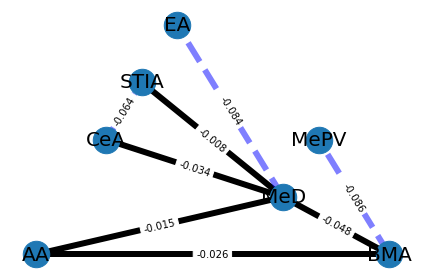

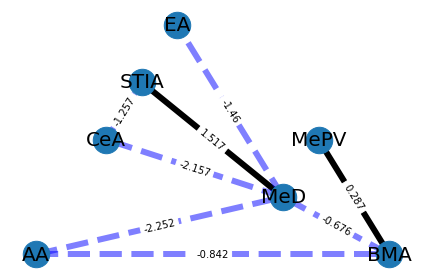

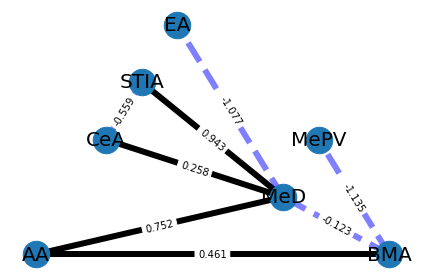

In [65]:
df_sum_aff_theta = df_sum2.loc[(df_sum2['sociability']=='affiliative')&(df_sum2['frequency_band']=='4-12')][['area1','area2','mean','zscore_mean']]
df_sum_avv_theta = df_sum2.loc[(df_sum2['sociability']=='aversive')&(df_sum2['frequency_band']=='4-12')][['area1','area2','mean','zscore_mean']]

area1_aff = df_sum_aff_theta['area1'].values
area2_aff = df_sum_aff_theta['area2'].values

area1_avv = df_sum_avv_theta['area1'].values
area2_avv = df_sum_avv_theta['area2'].values

means_aff = df_sum_aff_theta['mean'].values
means_avv = df_sum_avv_theta['mean'].values
mean_all = np.array([means_aff,means_avv]).mean()

zscore_aff = df_sum_aff_theta['zscore_mean'].values
zscore_avv = df_sum_avv_theta['zscore_mean'].values
mean_zscore_all = np.array([zscore_aff,zscore_avv]).mean()

pos, ax1 = plot_network(area1_aff, area2_aff, means_aff  ,_ , th=mean_all)
_, ax2 = plot_network(area1_avv, area2_avv, means_avv  ,pos , th=mean_all)

pos, ax1 = plot_network(area1_aff, area2_aff, zscore_aff  ,_ , th=0)
_, ax2 = plot_network(area1_avv, area2_avv, zscore_avv  ,pos , th=0)

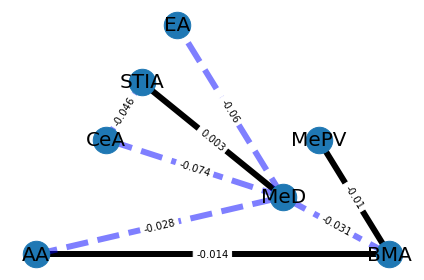

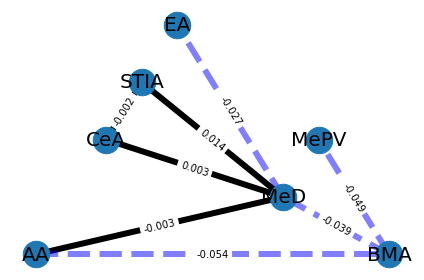

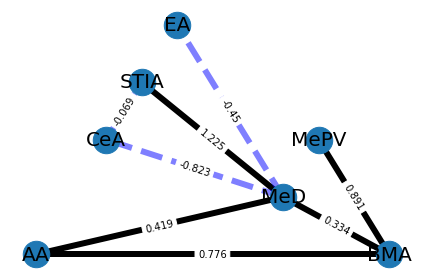

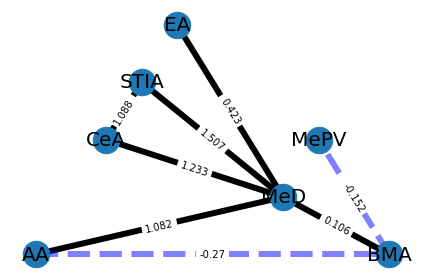

In [66]:
# Gamma

df_sum_aff_gamma = df_sum2.loc[(df_sum2['sociability']=='affiliative')&(df_sum2['frequency_band']=='30-80')][['area1','area2','mean','zscore_mean']]
df_sum_avv_gamma = df_sum2.loc[(df_sum2['sociability']=='aversive')&(df_sum2['frequency_band']=='30-80')][['area1','area2','mean','zscore_mean']]

area1_aff = df_sum_aff_gamma['area1'].values
area2_aff = df_sum_aff_gamma['area2'].values

area1_avv = df_sum_avv_gamma['area1'].values
area2_avv = df_sum_avv_gamma['area2'].values

means_aff = df_sum_aff_gamma['mean'].values
means_avv = df_sum_avv_gamma['mean'].values
mean_all = np.array([means_aff,means_avv]).mean()

zscore_aff = df_sum_aff_gamma['zscore_mean'].values
zscore_avv = df_sum_avv_gamma['zscore_mean'].values
mean_zscore_all = np.array([zscore_aff,zscore_avv]).mean()

pos, ax1 = plot_network(area1_aff, area2_aff, means_aff  ,_ , th=mean_all)
_, ax2 = plot_network(area1_avv, area2_avv, means_avv  ,pos , th=mean_all)

pos, ax1 = plot_network(area1_aff, area2_aff, zscore_aff  ,_ , th=0)
_, ax2 = plot_network(area1_avv, area2_avv, zscore_avv  ,pos , th=0)




## Predictive model for rat group

In [122]:
from sklearn.model_selection import train_test_split



In [333]:
common_pairs

{('AA', 'BMA'),
 ('AA', 'MeD'),
 ('BMA', 'MeD'),
 ('BMA', 'MePV'),
 ('CeA', 'MeD'),
 ('CeA', 'STIA'),
 ('EA', 'MeD'),
 ('MeD', 'STIA')}

In [294]:
def reformat_df(df, pair, social, range_of_freq='First'):
    
    df = df[social].copy()
    all_sheet_names = df.keys()
    sheet_name = [n for n in all_sheet_names if range_of_freq in n and pair[0] in n][0]
    
    
    
    df = df[sheet_name].copy()
    
    df = df.transpose()
    df = pd.concat([df], keys=[pair[0]])
    df.drop
    return df
    
   




In [570]:
significant_names

[('4-12', 'AA', 'MeD'),
 ('4-12', 'CeA', 'MeD'),
 ('30-80', 'AA', 'MeD'),
 ('30-80', 'CeA', 'MeD'),
 ('30-80', 'CeA', 'STIA')]

In [564]:
sociability = {'affiliative':df_file_paths_aff,'aversive':df_file_paths_avv}
df_sociability = {'affiliative':df_aff,'aversive':df_avv}
df_sum3 = {}
inds_for_filter = {}
for social in sociability.keys():
    df_sum_list = []
    for pair in common_pairs:
            for freq in frequency_bands.keys():
                df_out = reformat_df(
                    df=df_sociability,
                    pair=pair,
                    social=social,
                range_of_freq=freq)
                
                temp_df = pd.concat([df_out], axis=0, 
                              keys=[frequency_bands[freq]]).transpose()
                
                df_sum_list.append(temp_df.transpose())
    df_sum_temp = pd.concat(df_sum_list)

    df_sum_temp = df_sum_temp.dropna(axis=0, how='all')
    df_sum_temp = df_sum_temp.transpose()
    
        # Keep only common pairs
#     columns_to_keep = [a for a in df_sum_temp.columns if (a[1], a[2]) in common_pairs]
    columns_to_keep = [a for a in df_sum_temp.columns if (a[0], a[1], a[2]) in significant_names]
    df_sum_temp = df_sum_temp[columns_to_keep]
    
    df_sum3[social] = df_sum_temp
df_sum3 = pd.concat(df_sum3)
df_sum3 = df_sum3.dropna(axis=0, how='all')

df_sum3.index.set_names(['social', 'ind'], inplace=True)
df_sum3.reset_index(inplace=True)

C:\Users\user\anaconda3\lib\site-packages\IPython\core\async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


In [569]:
temp_df

30-80                                     
      EA                                     
    MePV STIA CeA  AA  EA       MeD       BMA
0    NaN  NaN NaN NaN NaN  0.094486       NaN
1    NaN  NaN NaN NaN NaN -0.062957       NaN
2    NaN  NaN NaN NaN NaN -0.108037       NaN
3    NaN  NaN NaN NaN NaN -0.015752       NaN
4    NaN  NaN NaN NaN NaN       NaN       NaN
5    NaN  NaN NaN NaN NaN       NaN       NaN
6    NaN  NaN NaN NaN NaN       NaN       NaN
7    NaN  NaN NaN NaN NaN       NaN       NaN
8    NaN  NaN NaN NaN NaN       NaN       NaN
9    NaN  NaN NaN NaN NaN       NaN       NaN
10   NaN  NaN NaN NaN NaN       NaN       NaN
11   NaN  NaN NaN NaN NaN       NaN       NaN
12   NaN  NaN NaN NaN NaN -0.001263       NaN
13   NaN  NaN NaN NaN NaN -0.003326       NaN
14   NaN  NaN NaN NaN NaN -0.035524       NaN
15   NaN  NaN NaN NaN NaN -0.279152       NaN
16   NaN  NaN NaN NaN NaN -0.076095       NaN
17   NaN  NaN NaN NaN NaN -0.035985  0.009215
18   NaN  NaN NaN NaN NaN  0.222181 -0.019240

In [535]:
df_file_paths_aff_reindex = pd.concat([df_file_paths_aff['lfp']], keys=['affiliative'], axis=0)
df_file_paths_avv_reindex = pd.concat([df_file_paths_avv['lfp']], keys=['aversive'], axis=0)


affiliative  0     chamber_Rat1-probe4-day1-Behavior_and_Optogene...
             1     chamber_Rat1-probe4-day2-Behavior_and_Optogene...
             2     chamber_Rat2-probe1-Sniffing-day1-Behavior_and...
             3     chamber_Rat2-probe1-sniffing-day2-Behavior_and...
             4     chamber_Rat2-probe1-sniffing-day3-Behavior_and...
             5     chamber_Rat3-probe2-sniffing-day2-Behavior_and...
             6     chamber_Rat3-Probe2-sniffing-Day3-Behavior_and...
             7     chamber_Rat4-probe3-sniffing-day1-Behavior_and...
             8     Chamber_Rat5_Probe8_day1_Behavior_and_Optogene...
             9     chamber_Rat5_probe8_day2_Behavior_and_Optogene...
             10    chamber_Rat5_probe8_day4_Behavior_and_Optogene...
             11    chamber_Rat8-Probe8-Day1-sniffing_Behavior_and...
             12    Chamber_Rat8-probe8-Day2-sniffing_Behavior_and...
             13    Chamber_Rat8-Probe12_day1_Behavior_and_Optogen...
             14    chamber_Rat8-pr

In [544]:
df = df_sum3.copy()
df.columns = df.columns.get_level_values(0)  # Reset column index
aff_inds = df.loc[df['social']=='affiliative']['ind'].values
avv_inds = df.loc[df['social']=='aversive']['ind'].values

df_file_paths_aff_reindex_selected = df_file_paths_aff_reindex.iloc[aff_inds]
df_file_paths_avv_reindex_selected = df_file_paths_avv_reindex.iloc[avv_inds]
df_file_paths_all = pd.concat([df_file_paths_aff_reindex_selected,df_file_paths_avv_reindex_selected])
df_file_paths_all = df_file_paths_all.values
df_sum3['files'] = df_file_paths_all

In [555]:
numeric_columns = df.select_dtypes(include='number')
features_mat = numeric_columns.drop('ind', axis=1).values
features_mat.shape

(31, 16)

In [563]:
df_sum3.columns

MultiIndex([('social',    '',    ''),
            (   'ind',    '',    ''),
            (  '4-12',  'AA', 'MeD'),
            (  '4-12',  'AA', 'MeD'),
            ( '30-80',  'AA', 'MeD'),
            ( '30-80',  'AA', 'MeD'),
            (  '4-12',  'AA', 'MeD'),
            (  '4-12',  'AA', 'MeD'),
            ( '30-80',  'AA', 'MeD'),
            ( '30-80',  'AA', 'MeD'),
            (  '4-12', 'CeA', 'MeD'),
            (  '4-12', 'CeA', 'MeD'),
            ( '30-80', 'CeA', 'MeD'),
            ( '30-80', 'CeA', 'MeD'),
            (  '4-12', 'CeA', 'MeD'),
            (  '4-12', 'CeA', 'MeD'),
            ( '30-80', 'CeA', 'MeD'),
            ( '30-80', 'CeA', 'MeD'),
            ( 'files',    '',    '')],
           )

In [559]:
significant_names

[('4-12', 'AA', 'MeD'),
 ('4-12', 'CeA', 'MeD'),
 ('30-80', 'AA', 'MeD'),
 ('30-80', 'CeA', 'MeD'),
 ('30-80', 'CeA', 'STIA')]

In [562]:
df_sum3[[('4-12', 'AA', 'MeD'),
 ('4-12', 'CeA', 'MeD'),
 ('30-80', 'AA', 'MeD'),
 ('30-80', 'CeA', 'MeD'),
 ('30-80', 'CeA', 'STIA')]]

KeyError: "[('30-80', 'CeA', 'STIA')] not in index"

In [ ]:
#sklearn.model_selection.train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)[